# Associations between SAT scores and demographics in NYC public schools

In this project, I will explore relationships between SAT scores and demographic factors at New York City public schools. Data for this project spanned 7 datasets from the City of New York, each linked below:

- SAT scores ([link](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4))
- School attendance ([link](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt))
- Class size ([link](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3))
- AP test reults ([link](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e))
- Graduation outcomes ([link](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a))
- Demographic information ([link](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j))
- Surveys of parents, teachers and students ([link](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8))

## Setup and load data

In [40]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt

%matplotlib inline

In [41]:
# data are stored in a series of .csv's
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

# data will be a dictionary storing all 6 dataframes
data = {}
for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [42]:
# additional survey data are stored as .txt's
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')

# join the survey dataframes
survey = pd.concat([all_survey, d75_survey], axis=0)

# rename dbn as DBN to be consistent with other data
survey["DBN"] = survey["dbn"]

# keep only relevant columns
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Add DBN columns

In [43]:
# rename dbn as DBN to be consistent with other data
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

# create and format DBN in class_size, which is missing DBN
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert relevant columns to numeric

In [44]:
# in sat_results, convert SAT score columns to numeric
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# in hs_directory, convert latitude and longitude values to numeric
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [45]:
# this step removes duplicate DBN entries in some dataframes

# filter class_size dataframe to include only grades 9-12 (high school)
# and GEN ED programs
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

# filter demographics dataframe to include only most recent year
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

# filter graduation dataframe to include only 2006 cohort and "Total Cohort" measurement
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [46]:
# convert relevant columns in ap_2010 dataframe to numeric
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine datasets

In [47]:
# combine all datasets using the pd.merge() function
combined = data["sat_results"]

# left join ap_2010 and graduation dataframes to sat_results
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

# inner join the rest
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

# fill columns with mean values, otherwise fill with 0
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

In [48]:
# get a single code for school district 
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Calculate correlation coefficients

In [49]:
# compute correlation matrix reflecting associations with sat_score and each variable
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


## Plot correlations

In [50]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

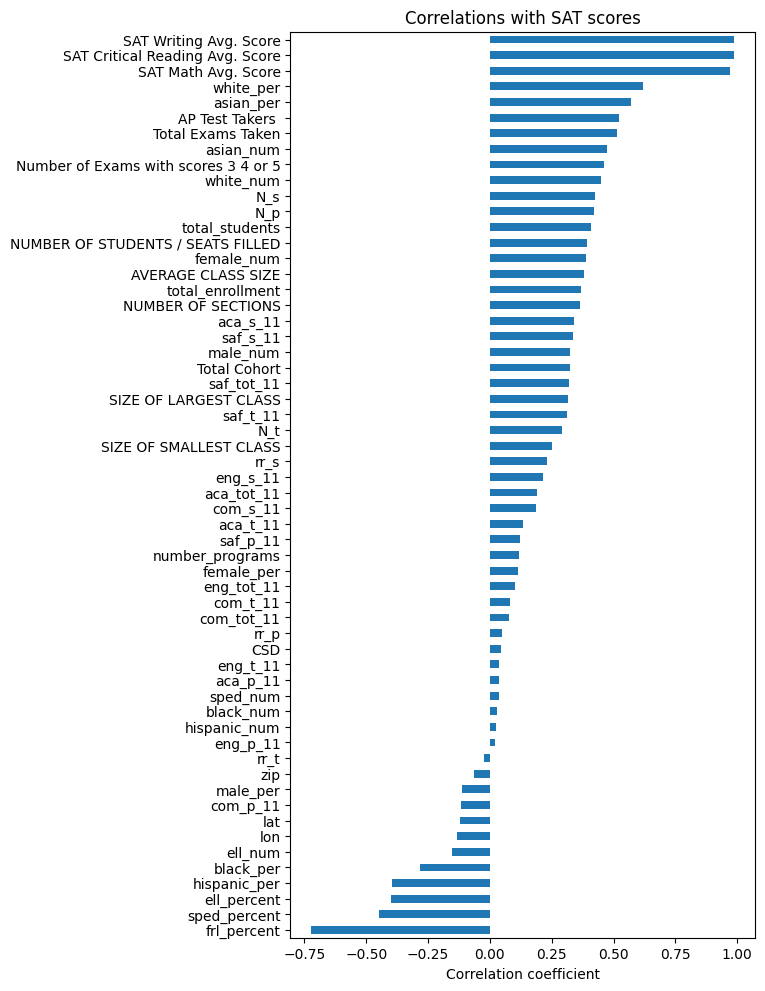

In [51]:
# create horizontal barplot of correlations
# removing NaN correlation values and sorting in descending order
correlations.drop('sat_score', axis=0).dropna().sort_values().plot(kind='barh', 
                                                                   figsize=(6,12),
                                                                   title = 'Correlations with SAT scores')
plt.xlabel('Correlation coefficient')
plt.show()

From the plot above, we can see that the percent of each white and asian students at a school correlated positively with SAT scores. The number of AP test takers at a school and the number of 3-5 scores on AP tests at a school also correlated positively with SAT scores.

Examining the variables that correlated negatively with SAT scores, we can see that a higher percent of English learners at a school was associated with lower SAT scores. In addition, the percent of each black and hispanic students at a school correlated negatively with SAT scores.

Other relationships of note include a positive correlation between total number of students and SAT scores, a positive correlation between the number of female students and SAT scores, and a negative correlation between the number of male students and SAT scores. In addition, `saf_t_11` and `saf_s_11`, which teacher and students perceptions of safety at school, correlated positively with SAT scores.

I'll unpack some of these patterns below.

## Examining the association between student perceived safety and SAT scores

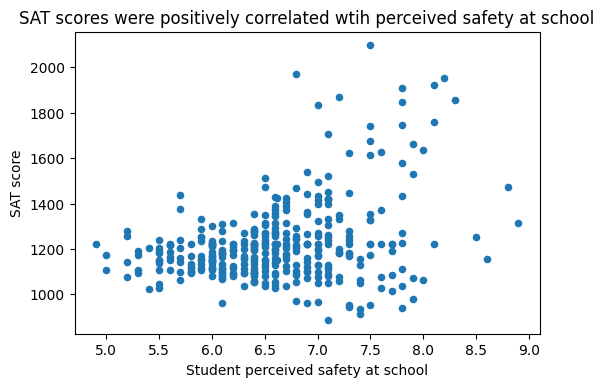

In [52]:
combined.plot.scatter(x='saf_s_11', y='sat_score')
plt.xlabel('Student perceived safety at school')
plt.ylabel('SAT score')
plt.title('SAT scores were positively correlated wtih perceived safety at school')
plt.show()

We can see that although there is a positive correlation, there are a handful of schools with low student perceived safety and low SAT scores. Next, we will try to identify which schools have low safety scores.

## How does student perceived safety vary by borough?

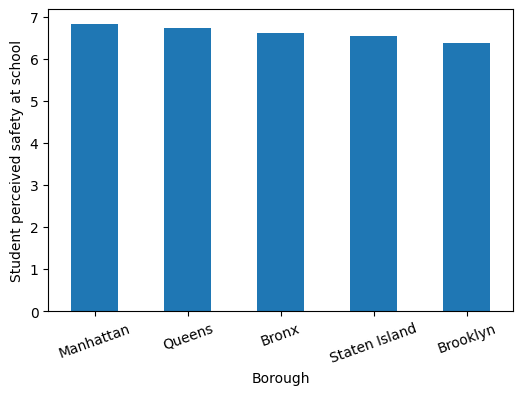

In [53]:
# next, we compute and plot safety scores for each borough, sorted in descending order
safety_boro = combined.groupby('boro').agg(numpy.mean)['saf_s_11']
safety_boro.sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=20)
plt.xlabel('Borough')
plt.ylabel('Student perceived safety at school')
plt.show()

We can see that students' ratings of perceived safety at school were highest at schools in Manhattan and lowest at schools in Brooklyn.

## Investigating racial differences in SAT scores

As we saw above, there were correlations between the percentage of each race at a given school and SAT scores:

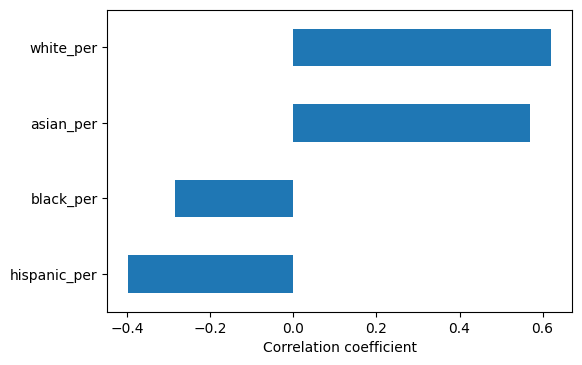

In [54]:
# create barplot focusing on correlations between racial percentages at a school and SAT scores
correlations[['asian_per', 'black_per', 'hispanic_per', 'white_per']].sort_values().plot(kind='barh')
plt.xlabel('Correlation coefficient')
plt.show()

Next, I'll focus on the negative correlation between % hispanic students and SAT scores:

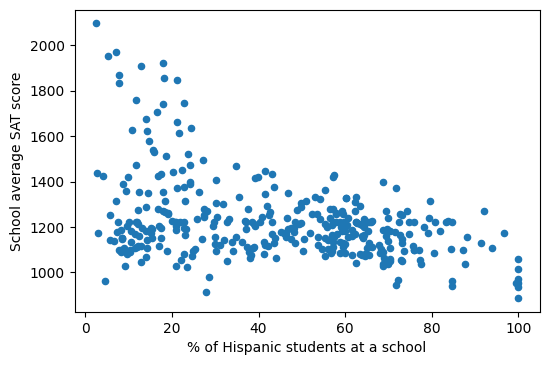

In [55]:
# create scatterplot of hispanic_per and sat_score
combined.plot.scatter(x='hispanic_per', y='sat_score')
plt.xlabel('% of Hispanic students at a school')
plt.ylabel('School average SAT score')
plt.show()

We can see that although there is a negative correlation, there are many schools with a high percentage of hispanic students and low average SAT scores.

Next, I'll try to better characterize these schools, by examining which schools have >95% hispanic students:

In [56]:
combined[combined['hispanic_per'] > 95][['SCHOOL NAME', 'boro']]

,SCHOOL NAME,boro
44,MANHATTAN BRIDGES HIGH SCHOOL,Manhattan
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,Manhattan
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,Manhattan
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,Bronx
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,Bronx
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,Bronx
253,MULTICULTURAL HIGH SCHOOL,Brooklyn
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,Queens


It looks like most of these schools have large proportions of English learners, which could actually be driving the relationship with SAT scores. Returning to the original correlation matrix, we can see that the percentage of English learners at a school was negatively correlated with average SAT score: 

In [57]:
correlations['ell_percent']

-0.3987497322085199

## Examining gender differences in SAT scores

As we saw above, SAT scores were positively correlated with the percentage of female students at a school and negatively correlated with the percentage of male students:

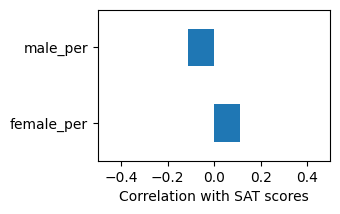

In [58]:
correlations[['female_per', 'male_per']].plot(kind='barh', figsize=(3,2))
plt.xlabel('Correlation with SAT scores')
plt.xlim([-0.5,0.5])
plt.show()

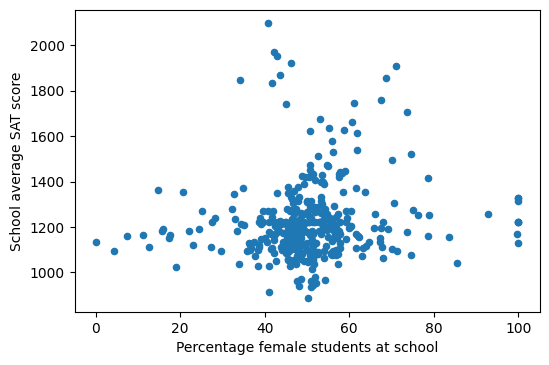

In [59]:
combined.plot.scatter(x='female_per', y='sat_score')
plt.xlabel('Percentage female students at school')
plt.ylabel('School average SAT score')
plt.show()

Although we saw a positive correlation above, it looks like this might be driven by a small set of schools having a high percentage of female students and high SAT scores.

Next, I'll investigate schools with high SAT scores and % female students greater than 60%.

In [60]:
combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1500)]

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
22,02M408,PROFESSIONAL PERFORMING ARTS HIGH SCHOOL,94,509.0,490.0,523.0,1522.0,PROFESSIONAL PERFORMING ARTS,20.000000,20.000000,...,0,0,0,0.0,0.0,0.0,"328 West 48 Street\nNew York, NY 10036\n(40.76...",40.761433,-73.988024,02
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,0,0,0,0.0,0.0,0.0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02
27,02M418,MILLENNIUM HIGH SCHOOL,144,528.0,553.0,533.0,1614.0,Millennium High School,86.000000,95.000000,...,0,0,0,0.0,0.0,0.0,"75 Broad Street\nNew York, NY 10004\n(40.70492...",40.704920,-74.011514,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,0,0,0,0.0,0.0,0.0,"227-243 West 61St Street\nNew York, NY 10023\n...",40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,0,0,0,0.0,0.0,0.0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03
287,24Q299,BARD HIGH SCHOOL EARLY COLLEGE II,155,545.0,568.0,550.0,1663.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"30-20 Thomson Avenue\nLong Island City, NY 111...",40.745094,-73.936814,24
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,0,0,0,0.0,0.0,0.0,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",40.734408,-73.821417,25
325,28Q680,QUEENS GATEWAY TO HEALTH SCIENCES SECONDARY SC...,99,513.0,523.0,502.0,1538.0,GATEWAY TO HEALTH SCIENCES,89.000000,136.000000,...,0,0,0,0.0,0.0,0.0,"160-20 Goethals Avenue\nJamaica, NY 11432\n(40...",40.718810,-73.806500,28


We can see that many of these schools include liberal arts and early college / college-preparatory programs, which could explain the positive correlation we observed between percentage female students and SAT scores. 

## Investigating the relationship between AP tests and SAT scores

We saw that the number of students who took AP exams was highly positively correlated with SAT scores. Yet the total school enrollment was also highly related to SAT scores, so we want to make sure that the relationship for AP exams was not just driven by this finding.

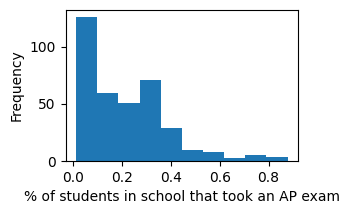

In [61]:
# calculate % of students in school that took AP exam
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined['ap_per'].plot(kind='hist', figsize=(3,2))
plt.xlabel('% of students in school that took an AP exam')
plt.show()

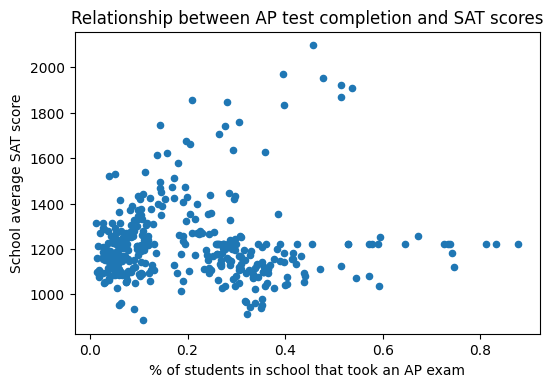

In [62]:
# create scatterplot of ap_per vs. SAT scores
combined.plot.scatter(x='ap_per', y='sat_score')
plt.xlabel('% of students in school that took an AP exam')
plt.ylabel('School average SAT score')
plt.title('Relationship between AP test completion and SAT scores')
plt.show()

The plot shows that the positive correlation we observed was likely driven by just a few schools. Instead, there is largely no relationship between the proportion of students that took an AP exam and SAT scores. Therefore, we can conclude the pattern was driven by a positive correlation between total enrollment and SAT scores:

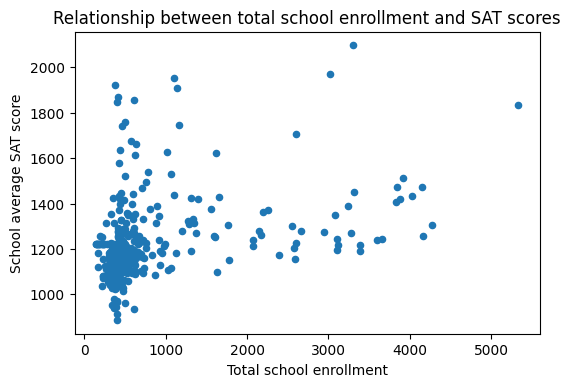

In [63]:
# create scatterplot of total_enrollment vs. SAT scores
combined.plot.scatter(x='total_enrollment', y='sat_score')
plt.xlabel('Total school enrollment')
plt.ylabel('School average SAT score')
plt.title('Relationship between total school enrollment and SAT scores')
plt.show()

## Summary

In this project, I examined relationships between various demographic variables and SAT scores at public schools in New York City. As a summary of what I found:

- SAT scores were higher at schools where students and teachers rated their perceived safety higher
- SAT scores were lower at schools with a higher percentage of English language learners
- SAT scores were higher at schools with a higher number of enrolled students